In [662]:
import NetworkArchitectures as nets
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from dataset_utils import Format_Dataset
from tqdm import tqdm

In [663]:
# Load in the Indianapolis Glaucoma Progression Study
data_dir = 'data/IGPS/'
results_dir = 'results/IGPS/'

features = [
    'IOP', 'MAP', 'SBP', 'DBP', 'HR', 'Qmean', 'P1', 'P2', 'P4', 'P5', 'R4', 'R5', 'trusoptBase', 'timololBase', 'Gen_Vision', 'macular_volume', 'mean_RNFL_thickness', 'Age', 'soft_green', 'soft_red', 'soft_blue', 'ProgressionStructure1', 'next_ProgressionStructure1'
]

features = [
    'IOP', 'MAP', 'SBP', 'DBP', 'HR', 'Qmean', 'P1', 'P2', 'P4', 'P5', 'R4', 'R5', 'next_ProgressionStructure1'
]

features = [
    'IOP', 'P1', 'P5', 'R4', 'Age', 'acuity', 'cup_disk_vert_ratio', 'cup_disk_horiz_ratio', 'mean_RNFL_thickness', 'next_ProgressionStructure1'
]

first, igps = True, None
for fn in sorted(os.listdir(data_dir)):
    if fn.endswith('.csv'):
        path = os.path.join(data_dir, fn)

        if first:
            igps = pd.read_csv(path)[features]  # grab only the features needed
            first = False
            continue

        df = pd.read_csv(path)[features]
        igps = pd.concat([igps, df])

# Possibly some missing data; lets fix it
def impute_col_KNN(df, col_name):
    col = df[[col_name]]
    imputer = KNNImputer(n_neighbors=5)
    col = imputer.fit_transform(col)
    df[col_name] = col

for f in features:
    print(f)
    if f != 'Hypertension':
        impute_col_KNN(igps, f)

first_visit = pd.read_csv(data_dir + 'year0_0.csv')[features]

for f in features:
    impute_col_KNN(first_visit, f)

first_visit = first_visit.drop(columns='next_ProgressionStructure1')

igps

IOP
P1
P5
R4
Age
acuity
cup_disk_vert_ratio
cup_disk_horiz_ratio
mean_RNFL_thickness
next_ProgressionStructure1


,IOP,P1,P5,R4,Age,acuity,cup_disk_vert_ratio,cup_disk_horiz_ratio,mean_RNFL_thickness,next_ProgressionStructure1
0,20.0,47.489951,19.316454,5689.152456,68.172485,0.14,0.490,0.464,0.28,0.0
1,18.0,41.983253,18.571021,5763.809295,68.501027,0.12,0.598,0.707,0.27,1.0
2,12.0,43.567630,19.048322,4121.464174,58.231348,-0.04,0.794,0.681,0.21,1.0
3,13.0,50.544863,20.265924,3952.890670,75.148528,0.08,0.637,0.694,0.25,1.0
4,20.0,53.856285,20.514162,5312.669706,71.887748,0.10,0.705,0.821,0.27,1.0
...,...,...,...,...,...,...,...,...,...,...
64,17.0,39.823806,18.243175,5652.671323,72.490075,-0.06,0.770,0.652,0.15,1.0
65,14.0,41.748648,18.673210,4689.228002,38.661191,0.02,0.751,0.790,0.04,1.0
66,4.0,46.703749,19.787909,2674.666564,82.762491,0.32,0.751,0.734,0.17,1.0
67,21.0,41.925701,17.987417,5940.162774,72.361396,0.38,0.890,0.948,0.18,1.0


In [664]:
# Preprocess this mess
split = int(0.8 * len(igps))
train = igps.iloc[:split]
test = igps.iloc[split:]

feat_count = len(features) - 1

train_X, train_y = train[features[:feat_count]], train[features[feat_count:]]
test_X, test_y = test[features[:feat_count]], test[features[feat_count:]]

train_X, train_y = train_X.to_numpy(), train_y.to_numpy()
test_X, test_y = test_X.to_numpy(), test_y.to_numpy()

first_visit = first_visit.to_numpy()    # the purpose of this line is to obtain the same verified clusters as we only use data from
                                        # the first visit to verify the clusters
print(train_X.shape)

# normalize the data
s = MinMaxScaler()
train_X = s.fit_transform(train_X)
test_X = s.transform(test_X)

first_visit = s.transform(first_visit)

dataset = {
    'samples': train_X,
    'labels': train_y
}

# Input layer basically
train = Format_Dataset(dataset, choice='Train')
train = torch.utils.data.DataLoader(shuffle=False, dataset=train, batch_size=6)

(496, 9)


In [665]:
params = {
    'k': 3,
    'data': first_visit,
    'sigma': 0.75,
    'mode': 1,
    'n_perceptrons': 1
}

rbf = nets.RBF(**params)
loss_fn = nn.BCELoss()
sgd = optim.Adam(rbf.parameters(), lr=0.001)

list(rbf.parameters())

[Parameter containing:
 tensor([0.7500, 0.7500, 0.7500], dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([[0.3985, 0.5066, 0.5460, 0.5287, 0.6885, 0.2925, 0.6663, 0.6983, 0.3803],
         [0.4492, 0.3697, 0.4064, 0.6831, 0.6827, 0.2929, 0.7119, 0.7433, 0.3655],
         [0.4439, 0.3856, 0.4217, 0.6625, 0.6397, 0.2736, 0.5670, 0.5935, 0.4054]],
        dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([[-0.1856, -0.3166, -0.3302]], dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([-0.1098], dtype=torch.float64, requires_grad=True)]

Training... :   0%|          | 0/2000 [00:00<?, ?it/s]/Users/mikeyjoyce/Documents/Grad School/NeuralNets/Project1/NetworkArchitectures.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.exp(-torch.pow(torch.tensor(x, dtype=torch.float64).unsqueeze(1) - self.centers, 2).sum(dim=2) / (2 * self.covar**2))
Training... : 100%|██████████| 2000/2000 [02:22<00:00, 14.03it/s]


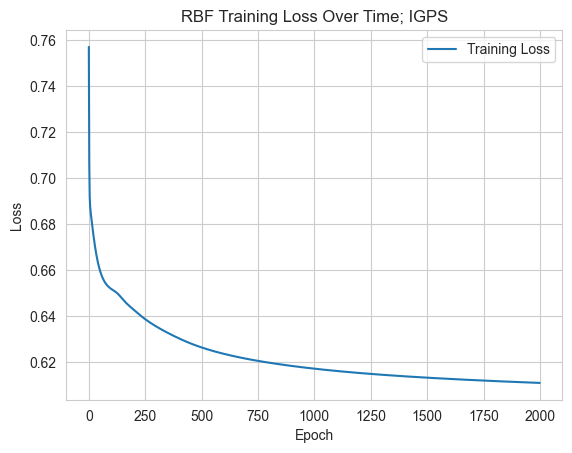

In [666]:
epochs = 2000

loss_vals = []
for epoch in tqdm(range(epochs), 'Training... '):
    temp_loss = []
    for samples, labels in train:
        output = rbf(samples)

        #print(output)
        #print(labels)
        loss = loss_fn(output, labels)

        sgd.zero_grad()
        loss.backward()
        sgd.step()

        temp_loss.append(loss.item())

    val = sum(temp_loss[-len(train):]) / len(train)
    if val <= 0.1:
        break
    loss_vals.append(val)

plt.plot(loss_vals, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('RBF Training Loss Over Time; IGPS')
plt.legend()
plt.savefig(results_dir + 'loss.png', dpi=900)
plt.show()

In [667]:
rbf.eval()
with torch.no_grad():
    out = rbf(torch.tensor(test_X)).detach().numpy()

#print("RBF neural network output: ", out)
print(list(rbf.parameters()))

preds = []
for i in range(len(out)):
    if out[i] >= 0.5:
        preds.append(1)
    else:
        preds.append(0)

preds

[Parameter containing:
tensor([0.4770, 0.3147, 0.2902], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([[0.1894, 0.7925, 0.8287, 0.2603, 0.9660, 0.2557, 1.1573, 0.7050, 0.7485],
        [0.5200, 0.4866, 0.4143, 0.5858, 0.5048, 0.0991, 0.4476, 0.1995, 0.6869],
        [0.2556, 0.0614, 0.1998, 0.5967, 0.8846, 0.8320, 0.3998, 0.5688, 0.3884]],
       dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([[ -5.5264,  -9.1295, -12.2741]], dtype=torch.float64,
       requires_grad=True), Parameter containing:
tensor([1.6804], dtype=torch.float64, requires_grad=True)]


[1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0]

Accuracy Score: 0.6
Precision Score: 0.5925925925925926
Recall Score: 0.7384615384615385
F1 Score:  0.6575342465753424


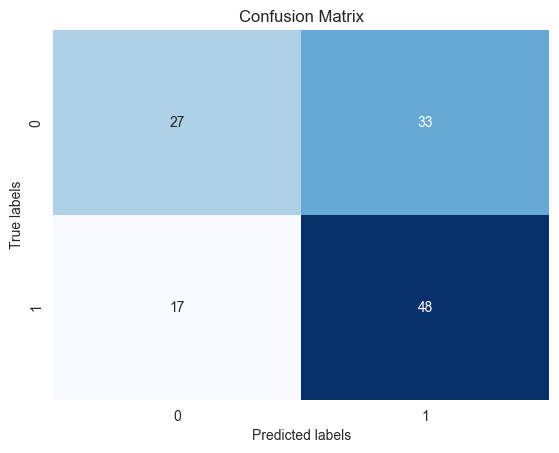

In [668]:
truth = list(test_y)

cm = confusion_matrix(truth, preds)

accuracy = accuracy_score(truth, preds)
print("Accuracy Score:", accuracy)

precision = precision_score(truth, preds)
print("Precision Score:", precision)

recall = recall_score(truth, preds)
print("Recall Score:", recall)

f1 = f1_score(truth, preds)
print("F1 Score: ", f1)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig(results_dir + 'confusion.png', dpi=900)
plt.show()